# Appendix
## Joseph Free
## EM

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

### 1. Function Definitions

In [2]:
# This function generates variates from a mixture of two normal distributions.
def mixture_dist(mu1, mu2, var1, var2, p1, p2=0, size=1):
    '''
    Generates variates from a mixture of two normal distributions.

    mu1: mean of first distribution.
    mu2: mean of second distribution.
    var1: variance of first distribution
    var2: variance of second distribution
    p1: mixture coefficient for first distribution. This is required.
    p2: mixture coefficient for the second distribution. This is optional. If not specified, this is set to 1-p1.
    size: Optional. Default value is 1. This allows one to generate a single value or a sequence of variates of length _size_.
    '''    
    # Check if weights are legal.
    if (p1>1) or (p2 != 0 and not (p1+p2 == 1)):
        print("Weights do not sum to 1")
        return None
    elif p2 == 0:
        p2 = 1-p1
    
    # If size is one, generate a single variate.
    if size == 1:
        if np.random.uniform() < p1:
            return np.random.normal(mu1,np.sqrt(var1))
        else:
            return np.random.normal(mu2,np.sqrt(var2))
    
    # If size is not one, generate 
    else:
        sample = np.array([])
        for i in range(0,size):
            if np.random.uniform() < p1:
                sample = np.append(sample, np.random.normal(mu1,np.sqrt(var1)))
            else:
                sample = np.append(sample, np.random.normal(mu2,np.sqrt(var2)))
        return sample
        

In [3]:
# This function applies the EM algorithm to a mixture of two normal distributions.
def EM_mix(mu1,mu2, v1,v2, p1, size=1000, tol=0.00001):
    '''
    This function uses the EM algorithm to approximate the mixture coefficients of a mixture of 
    two normal distributions.
    
    Inputs:
    
    mu1: mean of first distribution.
    mu2: mean of second distribution.
    v1: variance of first distribution
    v2: variance of second distribution
    p1: mixture coefficient for first distribution. This is required.
    size: Optional. Default value is 1. This allows one to generate a single value or a sequence of variates of length _size_.
    
    Output:
    
    The output of this function is a list of the estimated parameters and the estimated values at each iteration of the algorithm.
    
    '''
    
    # Generate sample
    samp = mixture_dist(mu1,mu2,v1,v2, p1, size = size)
    
    # Initialize guess proportion.
    pi0 = 0.5
    iteration = []
    for i in range(0,10000):
        # Calculate numerator and denominator of iterative procedure.
        numer = pi0*norm.pdf(samp, loc=mu1, scale=np.sqrt(v1))
        denom = numer + (1-pi0)*norm.pdf(samp, loc=mu2, scale=np.sqrt(v2))
        # Calculate ith iterate of latent variable.
        zk = numer/denom
        
        # Store previous proportion and calculate ith iterate of the
        # mixture coefficient.
        iteration.append(pi0)
        pi0 = sum(zk)/size
        if abs(pi0-iteration[i]) < tol:
            break
    
    return [(pi0, 1-pi0), iteration, p1 - pi0]

### 2. Testing and Diagnostics

In this section we seek to test the EM algorithms performance at estimating the mixture coefficients. To do so we focus on two main criteria: 1) speed of convergence and 2) accuracy. Furthermore, because the mixture components are univariate normal and on the real line, we additionally consider four possible relationships that exist between the component distributions, which is summarized in the table below:

| Location  	| Scale     	|
|-----------	|-----------	|
| Similar   	| Similar   	|
| Similar   	| Dissimilar 	|
| Dissimilar 	| Similar   	|
| Dissimilar 	| Dissimilar 	|

The crux of the testing approach is to evaluate the EM algorithm's performace using criteria 1) and 2) in each of these four categories. Intuitively we should expect the algorithm to perform better in some categories, and worse in others.

In [4]:
def diagnostics(img1_name='Figure 2: Mixture coefficient convergence',
                img2_name='Figure 3: Deviations from true mixture coefficient'):

    # Initialize random coefficient to be used in testing.
    random_proportion = np.random.uniform()
    print("Proportions:")
    print("-"*25)
    print("p1: " + str(random_proportion))
    print("p2: " + str(1-random_proportion))
    
    
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(img1_name)
    
    #NOTE: Not an elegant solution!

    # Case 1: Mean and variance similar
    ax = fig.add_subplot(2,2,1)
    ax.set_title("Case 1: Similar Means and Variances")

    case1_estimates = []
    case1_iterations = []
    for i in range(0,30):
        out = EM_mix(0, np.random.uniform(0, 1),
                     1, 1 + np.random.uniform(0, .5),
                     random_proportion,
                     size = 1000)
        case1_estimates.append(out[0][0])
        case1_iterations.append(len(out[1]))
        sns.lineplot(range(0,len(out[1])), out[1], ax=ax)
    ax.set_ylabel("Prop. Estimate")
    ax.axhline(y=random_proportion, ls='dashed', color = 'black')
    ax.axhline(y=1-random_proportion, ls='dashed', color = 'red')


    # Case 2: Means similar and variances dissimilar
    ax = fig.add_subplot(2,2,2)
    ax.set_title("Case 2: Similar Means and Dissimilar Variances")

    case2_estimates = []
    case2_iterations = []
    for i in range(0,30):
        out = EM_mix(0, np.random.uniform(0, .5),
                 1, 1 + np.random.uniform(0, 20),
                 random_proportion,
                 size = 1000)
        case2_estimates.append(out[0][0])
        case2_iterations.append(len(out[1]))
        sns.lineplot(range(0,len(out[1])), out[1], ax=ax)
    ax.axhline(y=random_proportion, ls='dashed', color = 'black')
    ax.axhline(y=1-random_proportion, ls='dashed', color = 'red')
    
    
    # Case 3: Means dissimilar and variances similar
    ax = fig.add_subplot(2,2,3)
    ax.set_title("Case 3: Dissimilar Means and Similar Variances")

    case3_estimates = []
    case3_iterations = []
    for i in range(0,30):
        out = EM_mix(0, np.random.uniform(10, 100),
                 1, 1 + np.random.uniform(0, .2),
                 random_proportion,
                 size = 1000)
        case3_estimates.append(out[0][0])
        case3_iterations.append(len(out[1]))
        sns.lineplot(range(0,len(out[1])), out[1], ax=ax)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Prop. Estimate")
    ax.axhline(y=random_proportion, ls='dashed', color = 'black')
    ax.axhline(y=1-random_proportion, ls='dashed', color = 'red')
    
    # Case 4: Means dissimilar and variances dissimilar
    ax = fig.add_subplot(2,2,4)
    ax.set_title("Case 4: Dissimilar Means and Variances")

    case4_estimates = []
    case4_iterations = []
    for i in range(0,30):
        out = EM_mix(0, np.random.uniform(10, 100),
                 1+np.random.uniform(20,40), 1 + np.random.uniform(0, 20),
                 random_proportion,
                 size = 1000)
        case4_estimates.append(out[0][0])
        case4_iterations.append(len(out[1]))
        sns.lineplot(range(0,len(out[1])), out[1], ax=ax)
    ax.set_xlabel("Iterations")
    ax.axhline(y=random_proportion, ls='dashed', color = 'black')
    ax.axhline(y=1-random_proportion, ls='dashed', color = 'red')
    
    plt.savefig('project 4/'+img1_name[0:8])
#############################################

    # Convert to more convenient data type
    case1_estimates = np.array(case1_estimates)
    case2_estimates = np.array(case2_estimates)
    case3_estimates = np.array(case3_estimates)
    case4_estimates = np.array(case4_estimates)

    # Plot histograms of deviations from true mixture coefficient.

    fig = plt.figure(figsize=(10,8))
    fig.suptitle(img2_name)

    ax = fig.add_subplot(2,2,1)
    ax.set_title("Case 1")
    sns.distplot(abs(case1_estimates-random_proportion), rug=True, ax=ax)
    ax = fig.add_subplot(2,2,2)
    ax.set_title("Case 2")
    sns.distplot(abs(case2_estimates-random_proportion), rug=True,color = 'green' ,ax=ax)
    ax = fig.add_subplot(2,2,3)
    ax.set_title("Case 3")
    ax.set_xlabel("Deviation")
    sns.distplot(abs(case3_estimates-random_proportion), rug=True,color='blue' ,ax=ax)
    ax = fig.add_subplot(2,2,4)
    ax.set_title("Case 4")
    sns.distplot(abs(case4_estimates-random_proportion),  rug=True,color='orange', ax=ax)
    ax.set_xlabel("Deviation")
    plt.savefig('project 4/'+img2_name[0:8])
    
    print("Case 1 Mean Iteration Length: ", np.mean(case1_iterations))
    print("Case 2 Mean Iteration Length: ", np.mean(case2_iterations))
    print("Case 3 Mean Iteration Length: ", np.mean(case3_iterations))
    print("Case 4 Mean Iteration Length: ", np.mean(case4_iterations))
    print("Case 1 Median Iteration Length: ", np.median(case1_iterations))
    print("Case 2 Median Iteration Length: ", np.median(case2_iterations))
    print("Case 3 Median Iteration Length: ", np.median(case3_iterations))
    print("Case 4 Median Iteration Length: ", np.median(case4_iterations))

Proportions:
-------------------------
p1: 0.04209553382949116
p2: 0.9579044661705088
Case 1 Mean Iteration Length:  563.6666666666666
Case 2 Mean Iteration Length:  129.73333333333332
Case 3 Mean Iteration Length:  2.0
Case 4 Mean Iteration Length:  2.933333333333333
Case 1 Median Iteration Length:  276.0
Case 2 Median Iteration Length:  105.0
Case 3 Median Iteration Length:  2.0
Case 4 Median Iteration Length:  2.0


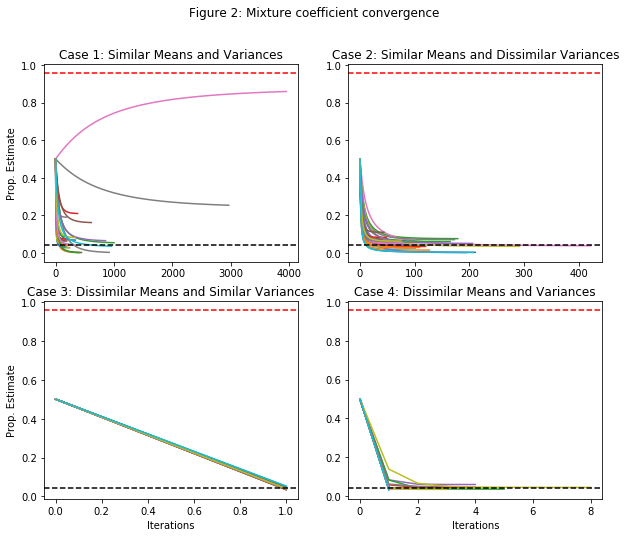

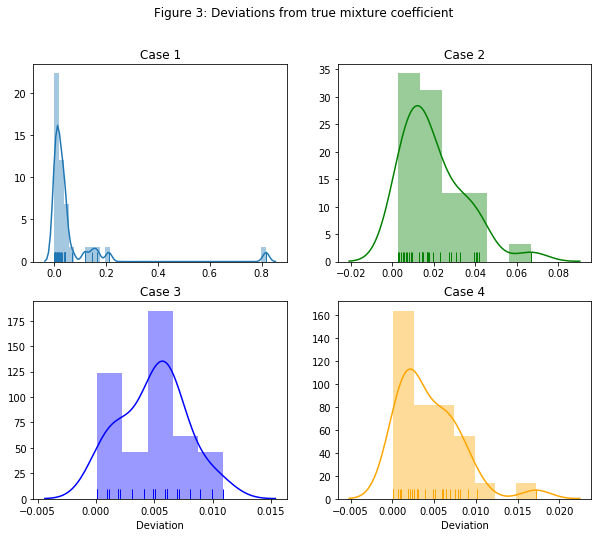

In [5]:
np.random.seed(829)
diagnostics()

Proportions:
-------------------------
p1: 0.152663734901322
p2: 0.847336265098678
Case 1 Mean Iteration Length:  550.3333333333334
Case 2 Mean Iteration Length:  95.56666666666666
Case 3 Mean Iteration Length:  2.0
Case 4 Mean Iteration Length:  2.933333333333333
Case 1 Median Iteration Length:  200.0
Case 2 Median Iteration Length:  42.0
Case 3 Median Iteration Length:  2.0
Case 4 Median Iteration Length:  2.0


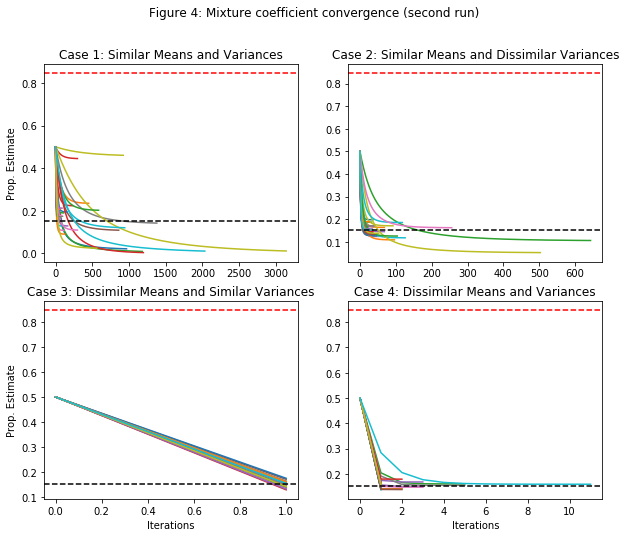

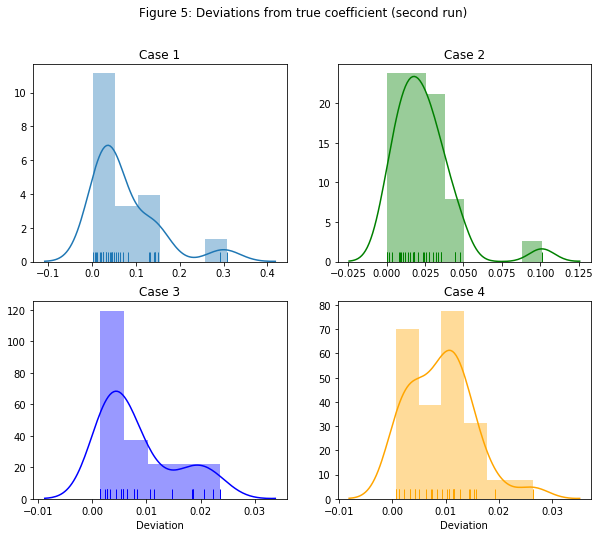

In [6]:
np.random.seed(777)
diagnostics("Figure 4: Mixture coefficient convergence (second run)",
            "Figure 5: Deviations from true coefficient (second run)")

Proportions:
-------------------------
p1: 0.6450392905877504
p2: 0.35496070941224955
Case 1 Mean Iteration Length:  413.9
Case 2 Mean Iteration Length:  24.133333333333333
Case 3 Mean Iteration Length:  2.0
Case 4 Mean Iteration Length:  3.3333333333333335
Case 1 Median Iteration Length:  134.5
Case 2 Median Iteration Length:  19.0
Case 3 Median Iteration Length:  2.0
Case 4 Median Iteration Length:  2.0


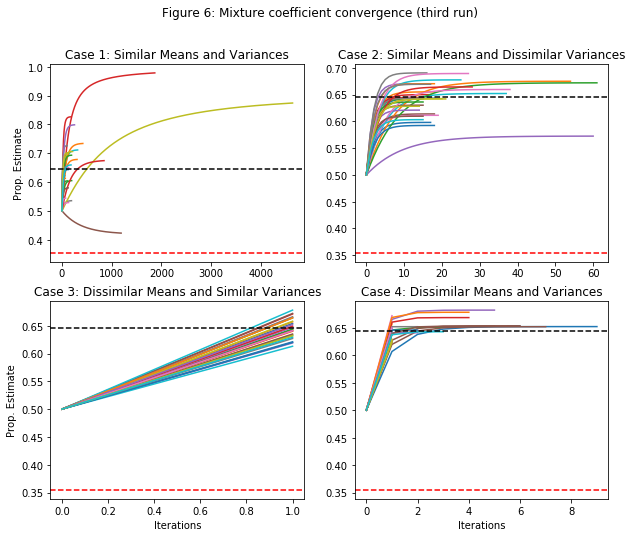

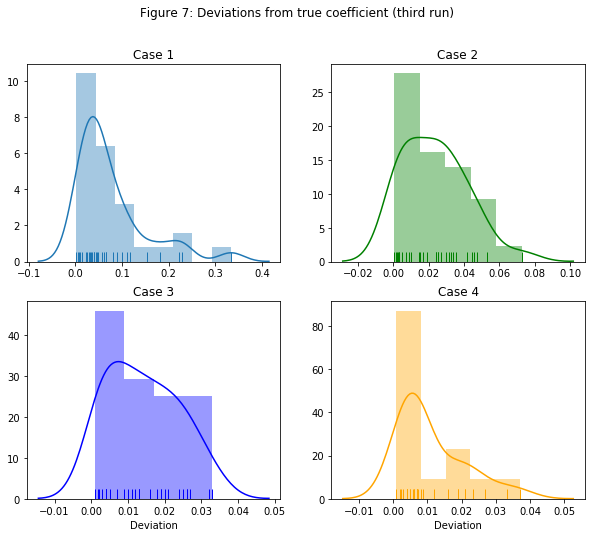

In [7]:
np.random.seed(1204)
diagnostics("Figure 6: Mixture coefficient convergence (third run)",
            "Figure 7: Deviations from true coefficient (third run)")